# Offsets calculations for full APT sequence
Calculations of X,Y offset for full APT sequence of R Aqr (two rolls) and PSF star

In [1]:
# Set up autoloader
%load_ext autoreload
%autoreload 2

In [2]:
# Set up modules and stuff
import numpy as np
import astropy.units as u
import compute_offsets as coff
import webbpsf as wp
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
import pysiaf
from pysiaf import Siaf

## JWST Parameters
Desired roll angles, coronagraphic masks and desired visits start times.

In [3]:
# JWST PA angle of the telescope V3 axis at time of observation
# V3PA range found in APT -> Visit Planner -> Reports -> Visit -> Total Roll
V3PA_TIME_R1  = 55.000 # V3PA at the JWST observing time (roll 1)
V3PA_TIME_R2  = 65.000 # V3PA at the JWST observing time (roll 2)
V3PA_TIME_REF = 65.000 # V3PA at the JWST observing time (reference)

# Coronographic mask ids
CORON_ID_A = '1140' # ID for first coronagraphic observation
CORON_ID_B = '1550' # ID for second coronagraphic observation

### Observation times for sequence calculation
The whole program is to be executed as an uninterruptible sequence. The time of the first visit is given in ATP as a "Between Dates" with the range of 1 hour; here is set in the middle of that time interval. The time of each following visit is calculated by adding the duration of the previous visit, ad given by the timeline in APT. All visits fits in the same day.

This is the start time, and duration, of each visit:
```
F1140C_R1:  time 00:30:00:000 ; duration 4200 sec = 01:10:00 hh:mm:ss
F1140C_R2:  time 01:40:00:000 ; duration 3000 sec = 00:50:00 hh:mm:ss
F1140C_REF: time 02:30:00:000 ; duration 6000 sec = 01:40:00 hh:mm:ss
F1150C_REF: time 04:10:00:000 ; duration 5100 sec = 01:25:00 hh:mm:ss
F1150C_R1:  time 05:35:00:000 ; duration 3100 sec = 00:52:00 hh:mm:ss
F1150C_R2:  time 06:27:00:000 ; duration 3100 sec = 00:52:00 hh:mm:ss
```

Need to check that all dates are UTC, and if it is necessary to have the time constraints as "After date" insted as uninterruptible sequence (as for alpha Cen). The after date constraint, however, could make the observations longer than the allotted time (by as much as 0.5 hour?)

In [4]:
# JWST dates and times
TIME_F1140C_R1 =  '2024-11-14T00:30:00.000'    # Begin R Aqr Roll 1, 11.4 um
TIME_F1140C_R2 =  '2024-11-14T01:40:00.000'    # Begin R Aqr Roll 2, 11.4 um
TIME_F1140C_REF = '2024-11-14T02:30:00.000'    # Begin T Cet, 11.4 um
TIME_F155OC_REF = '2024-11-14T04:10:00.000'    # Begin T Cet, 15.5 um
TIME_F1550C_R1 =  '2024-11-14T05:35:00.000'    # Begin R Aqr Roll 1, 15.5 um
TIME_F1550C_R2 =  '2024-11-14T06:27:00.000'    # Begin R Aqr Roll 2, 15.5 um

# Create Time-like objects with the JWST times
time_f1140c_r1 =  Time(TIME_F1140C_R1, format='isot', scale='utc')
time_f1140c_r2 =  Time(TIME_F1140C_R2, format='isot', scale='utc')
time_f1140c_ref = Time(TIME_F1140C_REF, format='isot', scale='utc')
time_f1550c_ref = Time(TIME_F155OC_REF, format='isot', scale='utc')
time_f1550c_r1 =  Time(TIME_F1550C_R1, format='isot', scale='utc')
time_f1550c_r2 =  Time(TIME_F1550C_R2, format='isot', scale='utc')

## Reference coordinates for all targets
We provide the most recent set of coordinates and proper motion for R Aqr based on our VLBI observations. The acquisition stars coordinates and the coordinates for chi Cet are from Gaia DR3.

### R Aqr astrometry

In [5]:
# R Aqr VLBI coordinates and proper motion
# This is the science target

RA = '23:43:49.50785 hours'     # RA in sexagesimal format (ICRS)
DEC = '-15:17:04.911 degrees'   # DEC in sexagesimal format (ICRS) 
PMRA = 27.33                    # Proper motion in RA (mas/yr)
PMDEC = -30.37                  # Proper motion in DEC (mas/yr)
PARALLAX = 4.59                 # Adriantsaralaza et al. 2022 parallax (mas)
OBS_DATE = '2024-04-07'         # Observation date
EPOCH = 2000.0                  # Reference epoch
FRAME = 'icrs'                  # Coordinate frame

# Create Skycoord object with the given coordinates
r_aqr = SkyCoord(RA,
                 DEC,
                 pm_ra_cosdec=PMRA*u.mas/u.yr,
                 pm_dec=PMDEC*u.mas/u.yr,
                 distance=Distance(parallax=PARALLAX*u.mas),
                 equinox=Time(EPOCH, format='jyear'),
                 obstime=Time(OBS_DATE, format='iso', scale='utc'),
                 frame=FRAME
                )

### R Aqr acquisition star astrometry

In [6]:
# Gaia DR3 2419576255768131328 coordinates
# This is the target acquisition star for the R Aqr observations
# The source has G = 19.4 and bp-rp = 3.11 : M4V according to
# https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

RA = '355.9498781532638 degrees'     # RA in decimal degrees (ICRS)
DEC = '-15.283947951921947 degrees'  # DEC in decimal degrees (ICRS) 
PMRA = 20.269224605443817            # Proper motion in RA (mas/yr)
PMDEC = -11.812614959581758          # Proper motion in DEC (mas/yr)
PARALLAX = 3.7063351210713535        # Gaia DR3 Parallax (mas)
OBS_DATE = 2016.0                    # Observation date
EPOCH = 2016.0                       # Reference epoch
FRAME = 'icrs'                       # Coordinate frame

# Create Skycoord object with the given coordinates
a_r_aqr = SkyCoord(RA,
                   DEC,
                   pm_ra_cosdec=PMRA*u.mas/u.yr,
                   pm_dec=PMDEC*u.mas/u.yr,
                   distance=Distance(parallax=PARALLAX*u.mas),
                   equinox=Time(EPOCH, format='jyear'),
                   obstime=Time(OBS_DATE, format='jyear', scale='tcb'),
                   frame=FRAME
                  )

### Chi Aqr (PSF reference) astrometry

In [7]:
# chi Aqr coordinates (Gaia DR3)
# This is the PSF reference star

RA = '349.2121666360522 degrees'     # RA in decimal degrees (ICRS)
DEC = '-7.7265601174932055 degrees'  # DEC in decimal degrees (ICRS) 
PMRA = -17.720811365972143           # Proper motion in RA (mas/yr)
PMDEC = -13.676336237987579          # Proper motion in DEC (mas/yr)
PARALLAX = 6.161173380222363         # Gaia DR3 Parallax (mas)
OBS_DATE = 2016.0                    # Observation date
EPOCH = 2016.0                       # Reference epoch
FRAME = 'icrs'                       # Coordinate frame

# Create Skycoord object with the given coordinates
c_aqr = SkyCoord(RA,
                 DEC,
                 pm_ra_cosdec=PMRA*u.mas/u.yr,
                 pm_dec=PMDEC*u.mas/u.yr,
                 distance=Distance(parallax=PARALLAX*u.mas),
                 equinox=Time(EPOCH, format='jyear'),
                 obstime=Time(OBS_DATE, format='jyear', scale='tcb'),
                 frame=FRAME
                )

### Chi Aqr acquisition star astrometry

In [8]:
# Gaia DR3 2630576351069481088 coordinates
# This is the target acquisition star for the chi Aqr observations
# The source has G = 18.9 and bp-rp = 1.66 : K7V according to
# https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

RA = '349.2107023418036 degrees'     # RA in decimal degrees (ICRS)
DEC = '-7.718557169510248 degrees'   # DEC in decimal degrees (ICRS) 
PMRA = 2.7933311354700763            # Proper motion in RA (mas/yr)
PMDEC = -11.06568676574391           # Proper motion in DEC (mas/yr)
PARALLAX = 0.935161266446918         # Gaia DR3 Parallax (mas)
OBS_DATE = 2016.0                    # Observation date
EPOCH = 2016.0                       # Reference epoch
FRAME = 'icrs'                       # Coordinate frame

# Create Skycoord object with the given coordinates
a_c_aqr = SkyCoord(RA,
                   DEC,
                   pm_ra_cosdec=PMRA*u.mas/u.yr,
                   pm_dec=PMDEC*u.mas/u.yr,
                   distance=Distance(parallax=PARALLAX*u.mas),
                   equinox=Time(EPOCH, format='jyear'),
                   obstime=Time(OBS_DATE, format='jyear', scale='tcb'),
                   frame=FRAME
                  )

## Update coordinates for all targets
Calculate updated positions for all targets (and acquisition stars) for the start time of each visit in qhich they are observed. For each visit check what is the offset between the acquisition star and the science target. For calculations, use the apply_space_motion() method of the SkyCoord package. 

### Visit 1: F1140C R1 (R Aqr Roll 1)

In [9]:
# Update R Aqr coordinates
r_aqr_f1140c_r1 = r_aqr.apply_space_motion(new_obstime=time_f1140c_r1)

# Update R Aqr acquisition star coordinates
a_r_aqr_f1140c_r1 = a_r_aqr.apply_space_motion(new_obstime=time_f1140c_r1)

### Visit 2: F1140C R2 (R Aqr Roll 2)

In [10]:
# Update R Aqr coordinates
r_aqr_f1140c_r2 = r_aqr.apply_space_motion(new_obstime=time_f1140c_r2)

# Update R Aqr acquisition star coordinates
a_r_aqr_f1140c_r2 = a_r_aqr.apply_space_motion(new_obstime=time_f1140c_r2)

### Visit 3: F1140C REF (chi Aqr)

In [11]:
# Update chi Aqr coordinates
c_aqr_f1140c_ref = c_aqr.apply_space_motion(new_obstime=time_f1140c_ref)

# Update chi Aqr acquisition star coordinates
a_c_aqr_f1140c_ref = a_c_aqr.apply_space_motion(new_obstime=time_f1140c_ref)

### Visit 4: F1550C REF (chi Aqr)

In [12]:
# Update chi Aqr coordinates
c_aqr_f1550c_ref = c_aqr.apply_space_motion(new_obstime=time_f1550c_ref)

# Update chi Aqr acquisition star coordinates
a_c_aqr_f1550c_ref = a_c_aqr.apply_space_motion(new_obstime=time_f1550c_ref)

### Visit 5: F1550C R1 (R Aqr Roll 1)

In [13]:
# Update R Aqr coordinates
r_aqr_f1550c_r1 = r_aqr.apply_space_motion(new_obstime=time_f1550c_r1)

# Update R Aqr acquisition star coordinates
a_r_aqr_f1550c_r1 = a_r_aqr.apply_space_motion(new_obstime=time_f1550c_r1)

### Visit 6: F1550C R2 (R Aqr Roll 2)

In [14]:
# Update R Aqr coordinates
r_aqr_f1550c_r2 = r_aqr.apply_space_motion(new_obstime=time_f1550c_r2)

# Update R Aqr acquisition star coordinates
a_r_aqr_f1550c_r2 = a_r_aqr.apply_space_motion(new_obstime=time_f1550c_r2)

### Calculate all offsets between the targets and their acquisition star

In [15]:
# Calculate offsets for each visit
offset_f1140c_r1 = a_r_aqr_f1140c_r1.separation(r_aqr_f1140c_r1).to(u.arcsec)
offset_f1140c_r2 = a_r_aqr_f1140c_r2.separation(r_aqr_f1140c_r2).to(u.arcsec)
offset_f1140c_ref = a_c_aqr_f1140c_ref.separation(c_aqr_f1140c_ref).to(u.arcsec)
offset_f1550c_ref = a_c_aqr_f1550c_ref.separation(c_aqr_f1550c_ref).to(u.arcsec)
offset_f1550c_r1 = a_r_aqr_f1550c_r1.separation(r_aqr_f1550c_r1).to(u.arcsec)
offset_f1550c_r2 = a_r_aqr_f1550c_r2.separation(r_aqr_f1550c_r2).to(u.arcsec)

# Print all offsets
print('--> Offsets between each target and its acquisition star:')
print(f'--> Offset for visit F1140C Roll 1: {offset_f1140c_r1:.6f}')
print(f'--> Offset for visit F1140C Roll 2: {offset_f1140c_r2:.6f}')
print(f'--> Offset for visit F1140C REF:    {offset_f1140c_ref:.6f}')
print(f'--> Offset for visit F1550C REF:    {offset_f1550c_ref:.6f}')
print(f'--> Offset for visit F1550C Roll 1: {offset_f1550c_r1:.6f}')
print(f'--> Offset for visit F1550C Roll 2: {offset_f1550c_r2:.6f}')

--> Offsets between each target and its acquisition star:
--> Offset for visit F1140C Roll 1: 22.231619 arcsec
--> Offset for visit F1140C Roll 2: 22.231620 arcsec
--> Offset for visit F1140C REF:    29.271230 arcsec
--> Offset for visit F1550C REF:    29.271229 arcsec
--> Offset for visit F1550C Roll 1: 22.231625 arcsec
--> Offset for visit F1550C Roll 2: 22.231625 arcsec


## Calculate APT offset for target acquisition
Uses the compute_offsets() script to calculate the X and y offset needed in APT to perform the target acquisition in offset from the acquisition star. This needs to be done for all visits (select correct time, and correct coronagraph). 

In [16]:
# Decide if plotting or not
SHOW_PLOTS = True
PLOT_FULL = True

### Visit 1: F1140C R1 (R Aqr Roll 1)

/Users/mmarengo/Work/Research/Software/github/jwst_offset/compute_offsets.py:896: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


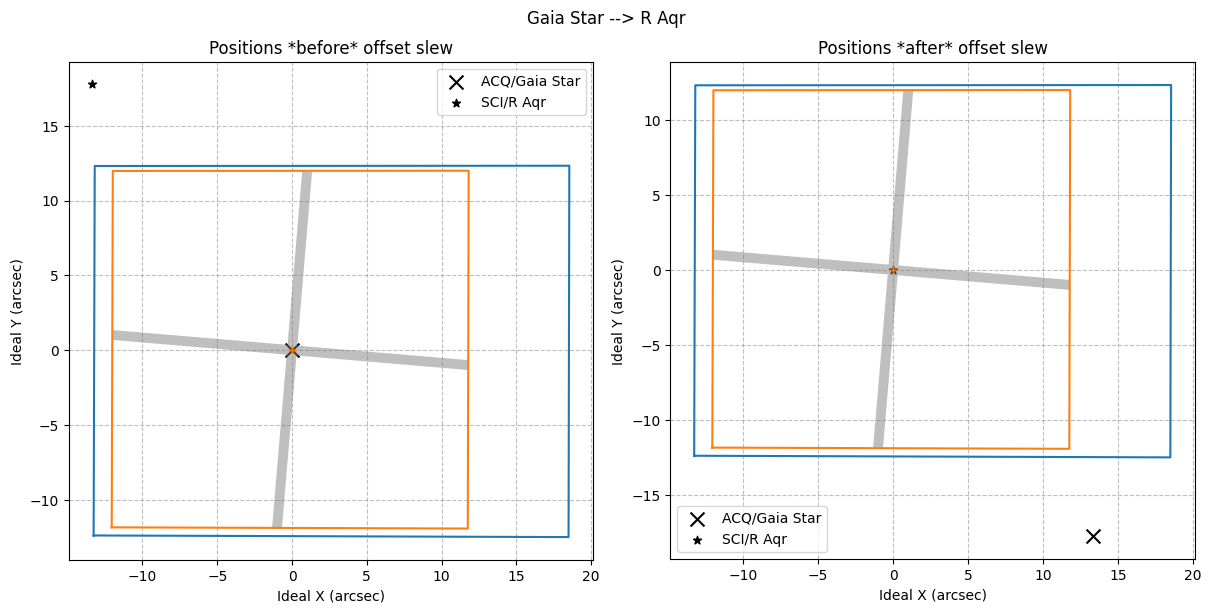

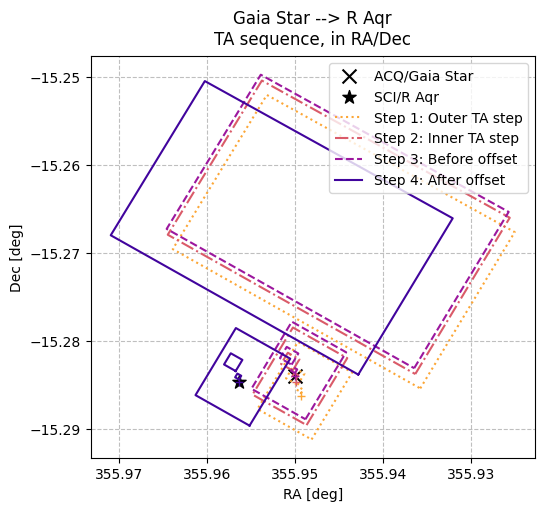

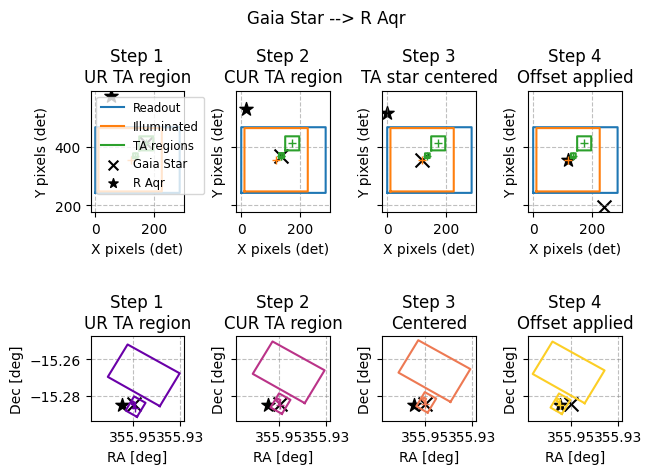

In [17]:
# Convert coordinates to degrees
T_RA = r_aqr_f1140c_r1.ra.deg
A_RA = a_r_aqr_f1140c_r1.ra.deg
T_DEC = r_aqr_f1140c_r1.dec.deg
A_DEC = a_r_aqr_f1140c_r1.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1140c_r1 = {'label': 'R Aqr', 
                     'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                    }
slew_fr_f1140c_r1 = {'label': 'Gaia Star', 
                     'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                    }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1140c_r1,
                              slew_to_f1140c_r1,
                              V3PA_TIME_R1,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1140c_r1 = dx
dy_f1140c_r1 = dy

### Visit 2: F1140C R2 (R Aqr Roll 2)

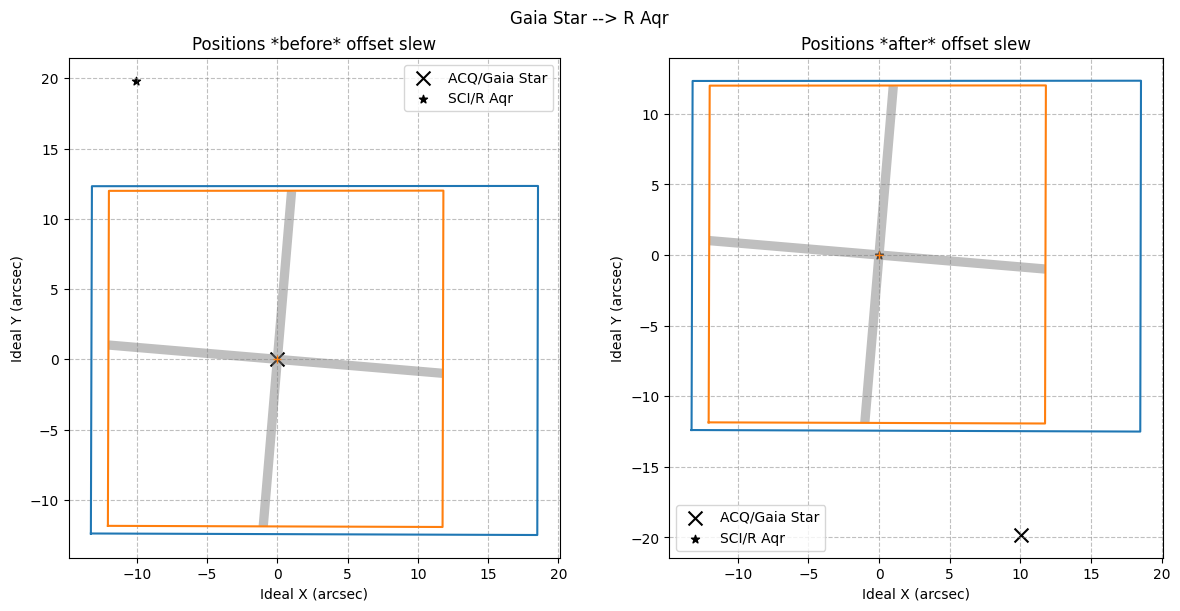

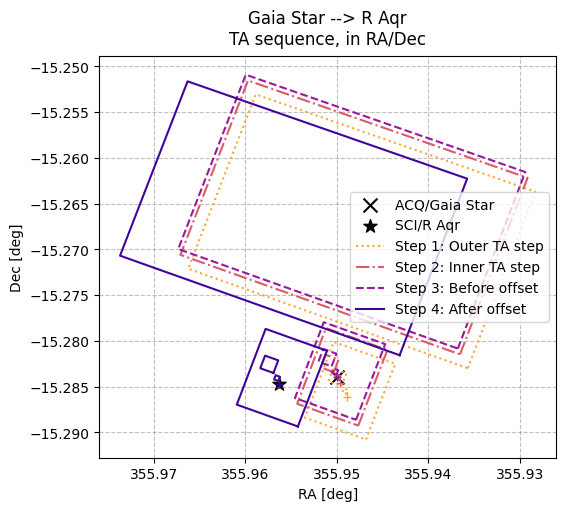

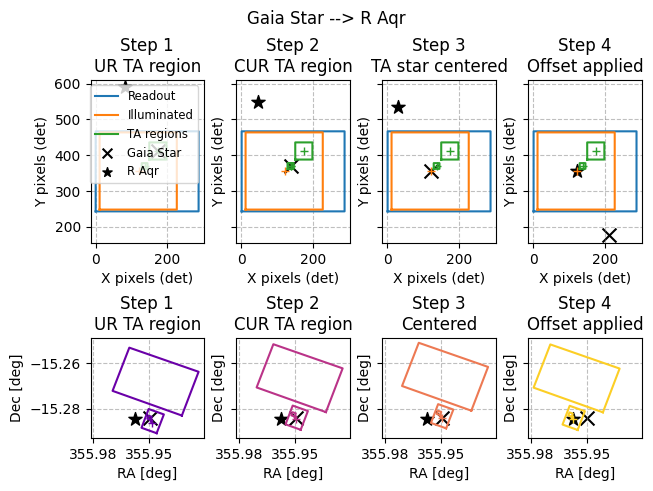

In [18]:
# Convert coordinates to degrees
T_RA = r_aqr_f1140c_r2.ra.deg
A_RA = a_r_aqr_f1140c_r2.ra.deg
T_DEC = r_aqr_f1140c_r2.dec.deg
A_DEC = a_r_aqr_f1140c_r2.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1140c_r2 = {'label': 'R Aqr', 
                     'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                    }
slew_fr_f1140c_r2 = {'label': 'Gaia Star', 
                     'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                    }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1140c_r2,
                              slew_to_f1140c_r2,
                              V3PA_TIME_R2,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1140c_r2 = dx
dy_f1140c_r2 = dy

### Visit 3: F1140C REF (chi Aqr)

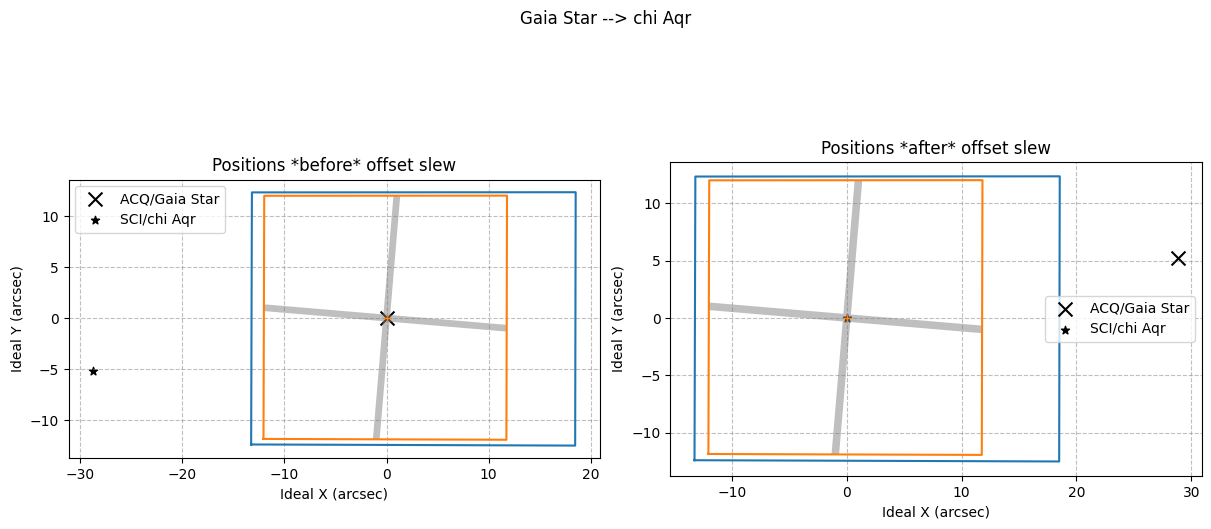

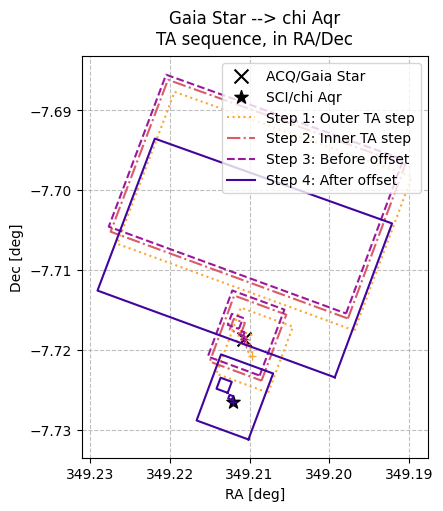

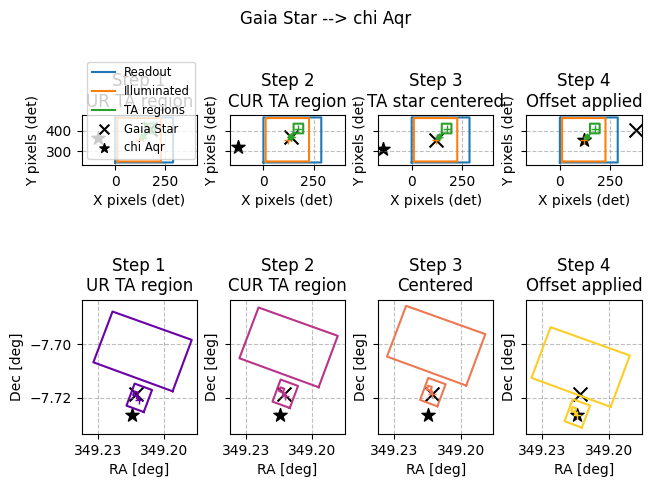

In [19]:
# Convert coordinates to degrees
T_RA = c_aqr_f1140c_ref.ra.deg
A_RA = a_c_aqr_f1140c_ref.ra.deg
T_DEC = c_aqr_f1140c_ref.dec.deg
A_DEC = a_c_aqr_f1140c_ref.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1140c_ref = {'label': 'chi Aqr', 
                      'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                     }
slew_fr_f1140c_ref = {'label': 'Gaia Star', 
                      'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                     }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1140c_ref,
                              slew_to_f1140c_ref,
                              V3PA_TIME_REF,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1140c_ref = dx
dy_f1140c_ref = dy

### Visit 4: F1550C REF (chi Aqr)

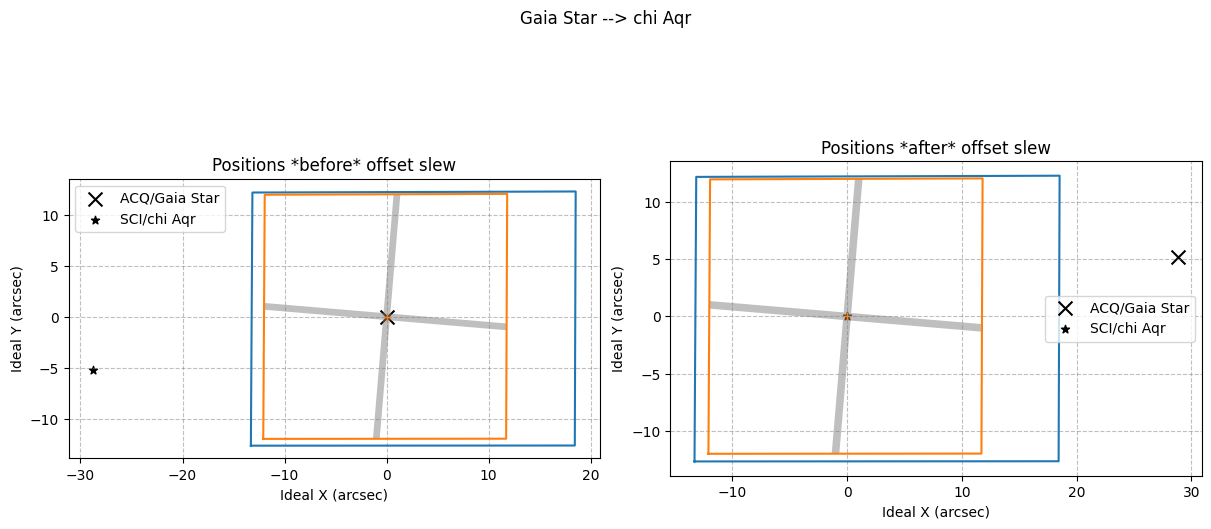

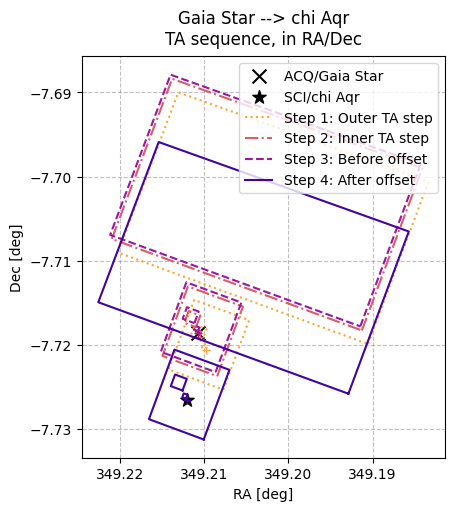

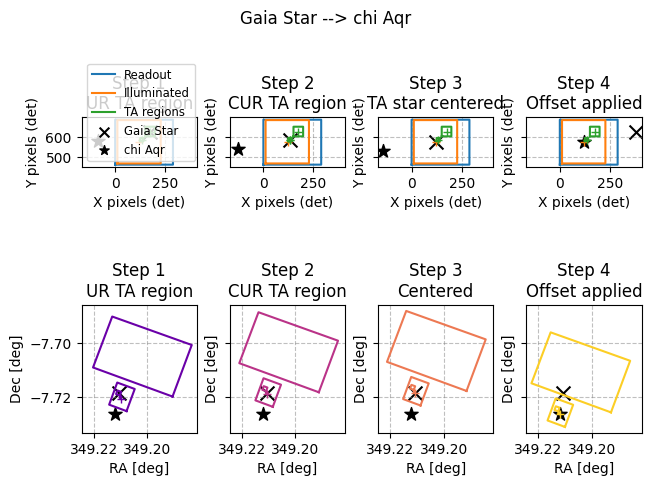

In [20]:
# Convert coordinates to degrees
T_RA = c_aqr_f1550c_ref.ra.deg
A_RA = a_c_aqr_f1550c_ref.ra.deg
T_DEC = c_aqr_f1550c_ref.dec.deg
A_DEC = a_c_aqr_f1550c_ref.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1550c_ref = {'label': 'chi Aqr', 
                      'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                     }
slew_fr_f1550c_ref = {'label': 'Gaia Star', 
                      'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                     }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1550c_ref,
                              slew_to_f1550c_ref,
                              V3PA_TIME_REF,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1550c_ref = dx
dy_f1550c_ref = dy

### Visit 5: F1550C R1 (R Aqr Roll 1)

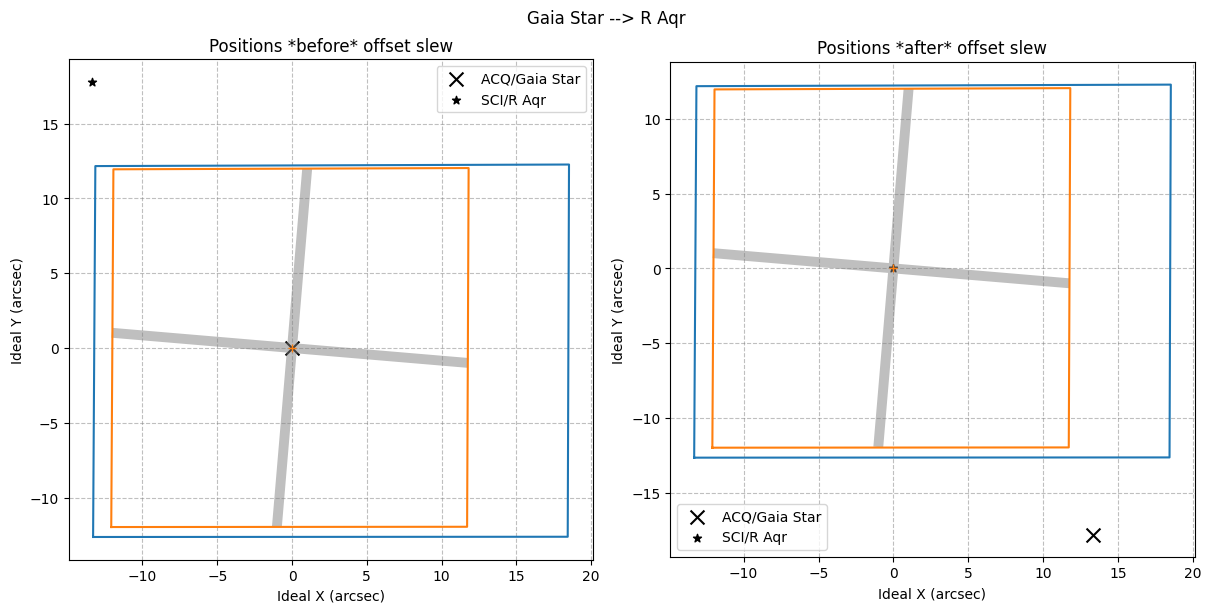

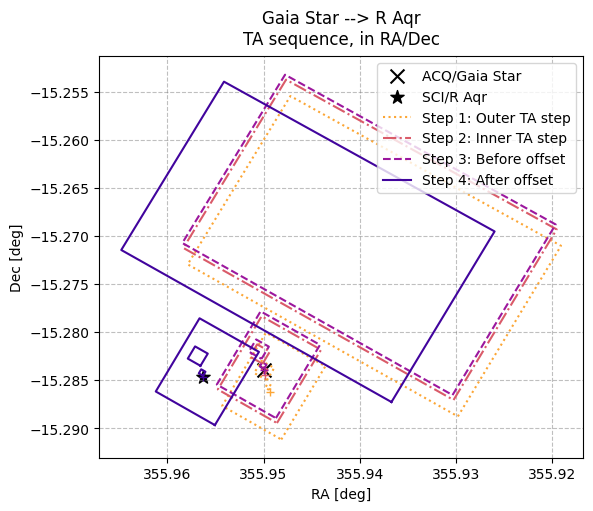

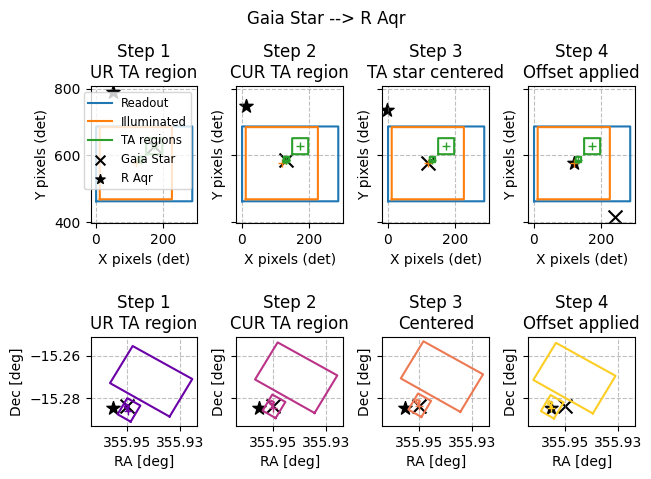

In [21]:
# Convert coordinates to degrees
T_RA = r_aqr_f1550c_r1.ra.deg
A_RA = a_r_aqr_f1550c_r1.ra.deg
T_DEC = r_aqr_f1550c_r1.dec.deg
A_DEC = a_r_aqr_f1550c_r1.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1550c_r1 = {'label': 'R Aqr', 
                     'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                    }
slew_fr_f1550c_r1 = {'label': 'Gaia Star', 
                     'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                    }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1550c_r1,
                              slew_to_f1550c_r1,
                              V3PA_TIME_R1,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1550c_r1 = dx
dy_f1550c_r1 = dy

### Visit 5: F1550C R2 (R Aqr Roll 1)

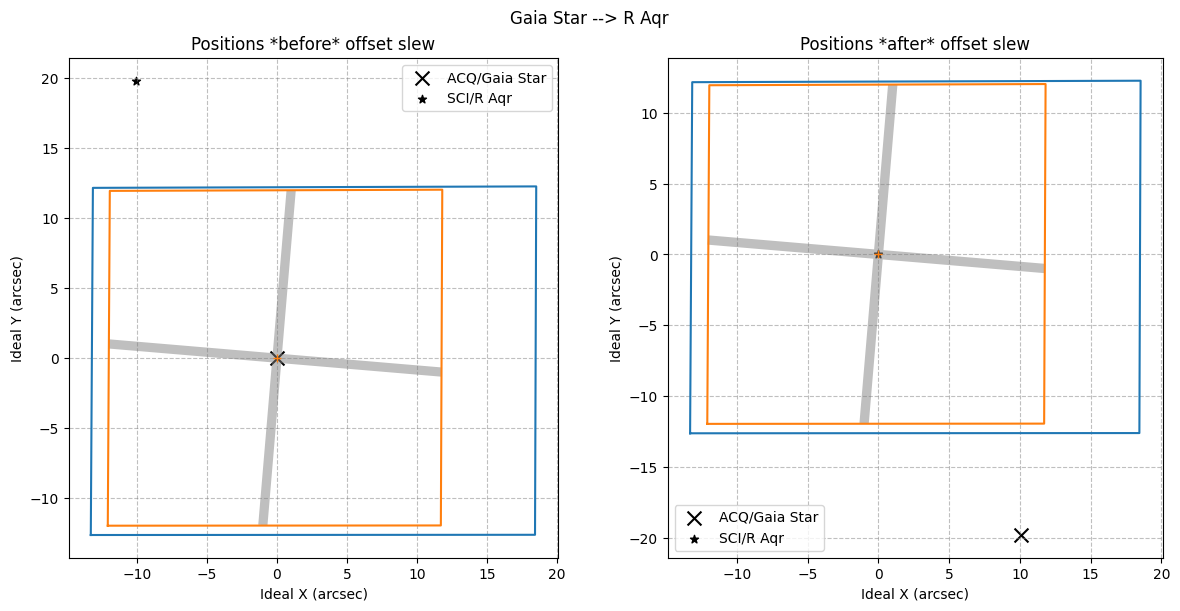

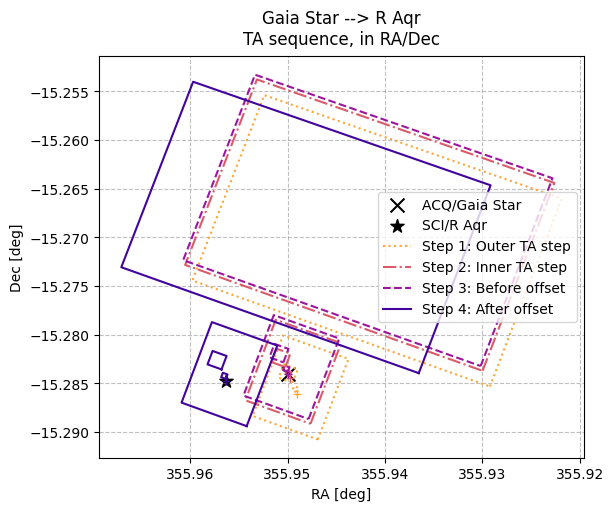

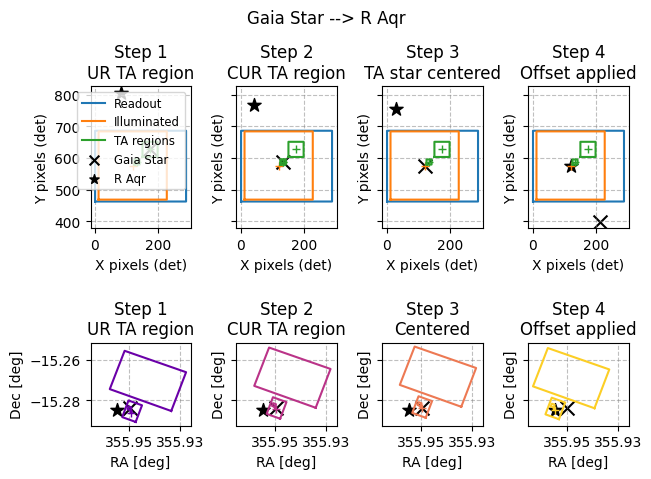

In [22]:
# Convert coordinates to degrees
T_RA = r_aqr_f1550c_r2.ra.deg
A_RA = a_r_aqr_f1550c_r2.ra.deg
T_DEC = r_aqr_f1550c_r2.dec.deg
A_DEC = a_r_aqr_f1550c_r2.dec.deg

# Setup initial and final slew coordinates for time of visit
slew_to_f1550c_r2 = {'label': 'R Aqr', 
                     'position': SkyCoord(T_RA, T_DEC, unit='deg', frame='icrs')
                    }
slew_fr_f1550c_r2 = {'label': 'Gaia Star', 
                     'position': SkyCoord(A_RA, A_DEC, unit='deg', frame='icrs')
                    }

# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_fr_f1550c_r2,
                              slew_to_f1550c_r2,
                              V3PA_TIME_R2,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Save offsets for posterity
dx_f1550c_r2 = dx
dy_f1550c_r2 = dy

### Print table with all offsets

In [23]:
# Print table with offsets and V3PA angles for all visits
print('--> OFFSETS AND V3PA ANGLES FOR ALL VISITS:')
print('')
print('Visit       |      dx     |      dy     |  V3PA')
print('            |   (arcsec)  |   (arcsec)  |  (deg)')
print('----------------------------------------------------')
print(f'F1140C R1   | {dx_f1140c_r1:+.7f} | {dy_f1140c_r1:+.7f} | '+
      f'{V3PA_TIME_R1:+.2f}')
print(f'F1140C R2   | {dx_f1140c_r2:+.7f} | {dy_f1140c_r2:+.7f} | '+
        f'{V3PA_TIME_R2:+.2f}')
print(f'F1140C REF  | {dx_f1140c_ref:+.7f} | {dy_f1140c_ref:+.7f} | '+
        f'{V3PA_TIME_REF:+.2f}')
print(f'F1550C REF  | {dx_f1550c_ref:+.7f} | {dy_f1550c_ref:+.7f} | '+
        f'{V3PA_TIME_REF:+.2f}')
print(f'F1550C R1   | {dx_f1550c_r1:+.7f} | {dy_f1550c_r1:+.7f} | '+
        f'{V3PA_TIME_R1:+.2f}')
print(f'F1550C R2   | {dx_f1550c_r2:+.7f} | {dy_f1550c_r2:+.7f} | '+
        f'{V3PA_TIME_R2:+.2f}')


--> OFFSETS AND V3PA ANGLES FOR ALL VISITS:

Visit       |      dx     |      dy     |  V3PA
            |   (arcsec)  |   (arcsec)  |  (deg)
----------------------------------------------------
F1140C R1   | +13.3522551 | -17.7753468 | +55.00
F1140C R2   | +10.0627459 | -19.8238890 | +65.00
F1140C REF  | +28.8044508 | +5.2068706 | +65.00
F1550C REF  | +28.8044436 | +5.2068752 | +65.00
F1550C R1   | +13.3522633 | -17.7753446 | +55.00
F1550C R2   | +10.0627542 | -19.8238889 | +65.00


## Calculate offsets in IDL coordinates

In [24]:
# Define MIRI apertures from Siaf database
miri = Siaf("MIRI")

# Convert sky coordinates to IDL coordinates
ta_f1140c_r1, sci_f1140c_r1 = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_r_aqr_f1140c_r1},
                     {'label': 'R Aqr', 'position': r_aqr_f1140c_r1}],
                     miri[f'MIRIM_MASK{CORON_ID_A}'], V3PA_TIME_R1)
ta_f1140c_r2, sci_f1140c_r2 = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_r_aqr_f1140c_r2},
                     {'label': 'R Aqr', 'position': r_aqr_f1140c_r2}],
                     miri[f'MIRIM_MASK{CORON_ID_A}'], V3PA_TIME_R2)
ta_f1140c_ref, sci_f1140c_ref = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_c_aqr_f1140c_ref},
                     {'label': 'chi Aqr', 'position': c_aqr_f1140c_ref}],
                     miri[f'MIRIM_MASK{CORON_ID_A}'], V3PA_TIME_REF)
ta_f1550c_ref, sci_f1550c_ref = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_c_aqr_f1550c_ref},
                     {'label': 'chi Aqr', 'position': c_aqr_f1550c_ref}],
                     miri[f'MIRIM_MASK{CORON_ID_B}'], V3PA_TIME_REF)
ta_f1550c_r1, sci_f1550c_r1 = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_r_aqr_f1550c_r1},
                     {'label': 'R Aqr', 'position': r_aqr_f1550c_r1}],
                     miri[f'MIRIM_MASK{CORON_ID_B}'], V3PA_TIME_R1)
ta_f1550c_r2, sci_f1550c_r2 = \
    coff.sky_to_idl([{'label': 'TA Star', 'position': a_r_aqr_f1550c_r2},
                     {'label': 'R Aqr', 'position': r_aqr_f1550c_r2}],
                     miri[f'MIRIM_MASK{CORON_ID_B}'], V3PA_TIME_R2)

In [25]:
# Print IDL coordinates of sci target for all visits
print('--> IDL COORDINATES OF SCIENCE TARGETS FOR ALL VISITS:')
print('--> F1140C R1 SCI: ', sci_f1140c_r1['position'])
print('--> F1140C R2 SCI: ', sci_f1140c_r2['position'])
print('--> F1140C REF:    ', sci_f1140c_ref['position'])
print('--> F1550C REF:    ', sci_f1550c_ref['position'])
print('--> F1550C R1 SCI: ', sci_f1550c_r1['position'])
print('--> F1550C R2 SCI: ', sci_f1550c_r2['position'])

--> IDL COORDINATES OF SCIENCE TARGETS FOR ALL VISITS:
--> F1140C R1 SCI:  [-13.35225508  17.77534682]
--> F1140C R2 SCI:  [-10.06274585  19.82388903]
--> F1140C REF:     [-28.80445078  -5.20687062]
--> F1550C REF:     [-28.80444358  -5.20687522]
--> F1550C R1 SCI:  [-13.35226334  17.77534462]
--> F1550C R2 SCI:  [-10.06275424  19.82388891]


## Generate scenes for TA configuration
Produce views in the location of the coronagraphic subarray with the TA star at the center, and the science target (R Aqr and PSF reference star) in the offset position calculated in IDL coordinates.

This assumes that WebbPSF recreates PSFs with the correct orientation with respect to the coronagraphic subarray.

### Define create_scene_psf routine

In [26]:
# Create scene for generic visit
def create_scene_psf(filter, aperture, idl_coords, flux_ratio,
                     scene_name, fov_pixels=1024, oversample=2, extens=3):
    """
    Plot a scene with the relative position of the science source
    and the target acquisition star for a given visit.

    Parameters
    ----------
    filter : str
        Filter to use for the scene.
    
    aperture : str
        Aperture to use for the scene.
    
    idl_coords : nparray[2]
        IDL x and y coordinates of PSF star in TA scene.
    
        flux_ratio : float
        Flux ratio between scientific target and acquisition star.
    
    fov_pixels : int (default=1024)
        Number of pixels in the field of view.
    
    oversample : int (default=2)
        Oversampling factor for the PSF.
    """

    # Define science target PSF parameters
    sci = wp.MIRI()
    sci.filter = filter
    sci.set_position_from_aperture_name(aperture)
    sci.options['source_offset_x'] = idl_coords['position'][0]
    sci.options['source_offset_y'] = idl_coords['position'][1]
    sci.options['source_offset_units'] = 'arcsec'

    # Define target acquisition star PSF parameters
    ta = wp.MIRI()
    ta.filter = filter
    ta.set_position_from_aperture_name(aperture)

    # Generate PSFs for science target and target acquisition star
    sci_psf = sci.calc_psf(fov_pixels=fov_pixels, oversample=oversample)
    ta_psf = ta.calc_psf(fov_pixels=fov_pixels, oversample=oversample)

    # Create scene with science target and target acquisition star
    sci_psf[extens].data *= flux_ratio
    sci_psf[extens].data += ta_psf[extens].data
    
    # Display scene
    wp.display_psf(sci_psf, ext=extens, title=scene_name)

    # So long and thanks for all the fisk
    return

### Create scene for F1140C R Aqr Roll 1

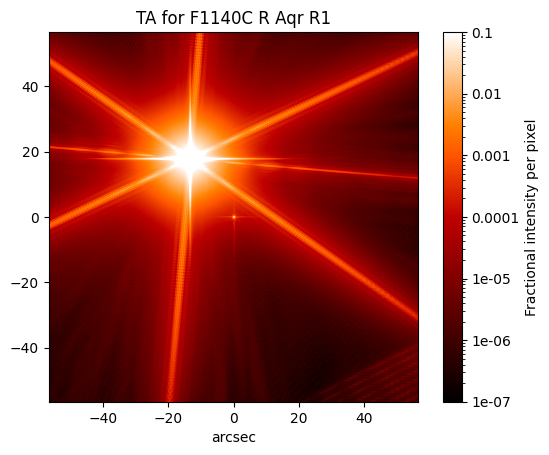

In [27]:
# Plot TA scene for F1140C R1
SCENE_NAME = 'TA for F1140C R Aqr R1'  # Title for the scene
APERTURE = 'MIRIM_MASK1140'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1140c_r1             # IDL coordinates of science target
PSF_FLUX_RATIO = 15000                 # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

### Create scene for F1140C R Aqr Roll 2

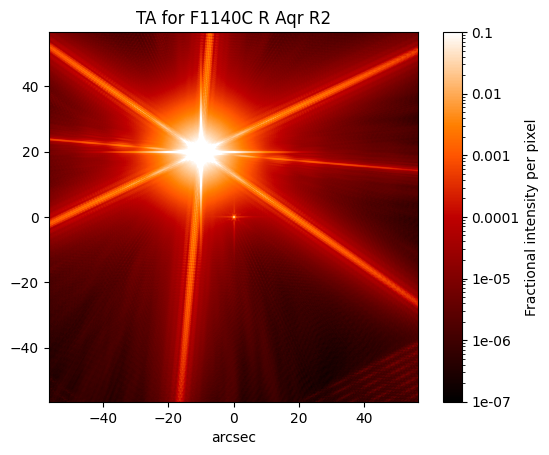

In [28]:
# Plot TA scene for F1140C R2
SCENE_NAME = 'TA for F1140C R Aqr R2'  # Title for the scene
APERTURE = 'MIRIM_MASK1140'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1140c_r2             # IDL coordinates of science target
PSF_FLUX_RATIO = 15000                 # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

### Create scene for F1440C chi Aqr (reference star)

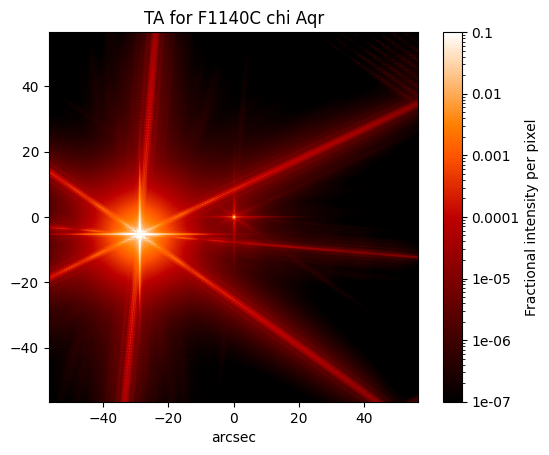

In [29]:
# Plot TA scene for F1140C REF
SCENE_NAME = 'TA for F1140C chi Aqr'   # Title for the scene
APERTURE = 'MIRIM_MASK1140'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1140c_ref            # IDL coordinates of science target
PSF_FLUX_RATIO = 1000                  # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

### Create scene for F1550C chi Aqr (reference star)

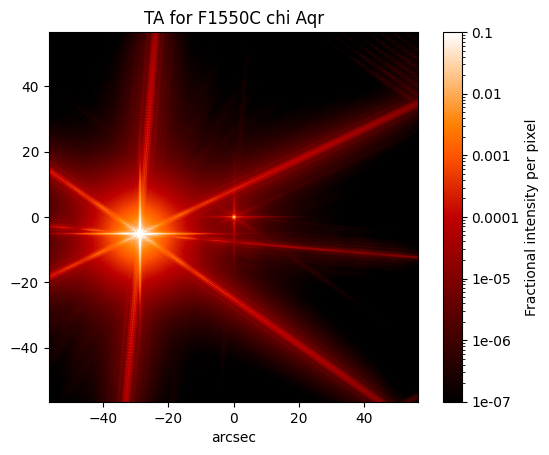

In [30]:
# Plot TA scene for F1550C REF
SCENE_NAME = 'TA for F1550C chi Aqr'   # Title for the scene
APERTURE = 'MIRIM_MASK1550'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1550c_ref            # IDL coordinates of science target
PSF_FLUX_RATIO = 1000                  # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

### Create scene for F1550C R Aqr Roll 1

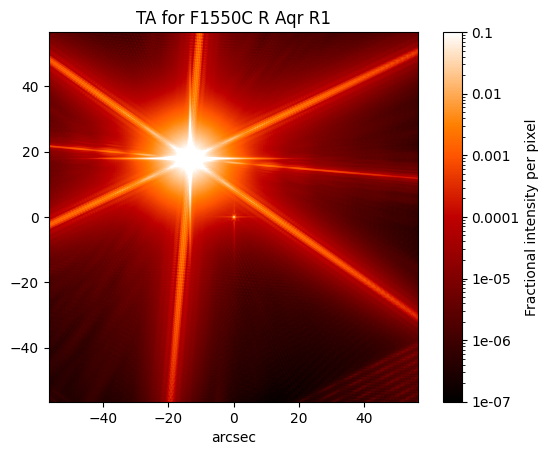

In [31]:
# Plot TA scene for F1550C R1
SCENE_NAME = 'TA for F1550C R Aqr R1'  # Title for the scene
APERTURE = 'MIRIM_MASK1550'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1550c_r1             # IDL coordinates of science target
PSF_FLUX_RATIO = 15000                 # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

### Create scene for F1550C R Aqr Roll 2

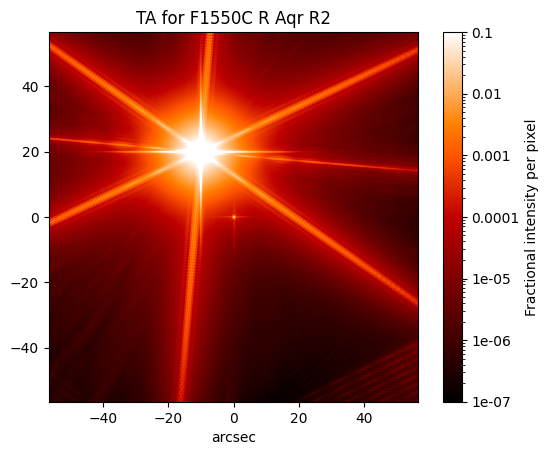

In [32]:
# Plot TA scene for F1550C R2
SCENE_NAME = 'TA for F1550C R Aqr R2'  # Title for the scene
APERTURE = 'MIRIM_MASK1550'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1550c_r2             # IDL coordinates of science target
PSF_FLUX_RATIO = 15000                 # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)

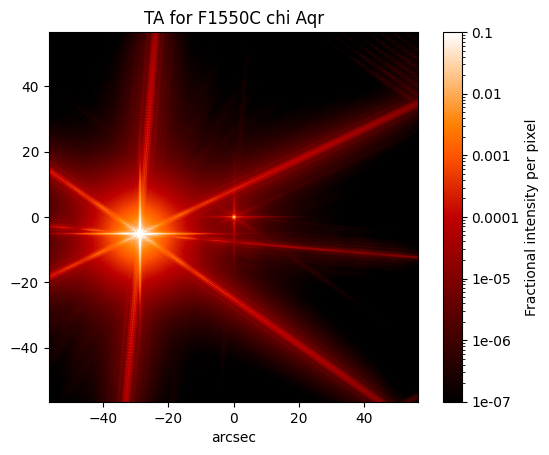

In [33]:
# Plot TA scene for F1550C REF
SCENE_NAME = 'TA for F1550C chi Aqr'   # Title for the scene
APERTURE = 'MIRIM_MASK1550'            # Location of coronagraphic subarray
FILTER = 'F560W'                       # Filter for TA acquisition
PSF_COORDS = sci_f1550c_ref            # IDL coordinates of science target
PSF_FLUX_RATIO = 1000                  # Flux ratio sci/TA star

# Shop scene
create_scene_psf(FILTER, APERTURE, PSF_COORDS, PSF_FLUX_RATIO, SCENE_NAME)